In [12]:
# IMPORTING PACKAGES

#Basics
import numpy as np # Basic math and array manipulation
import matplotlib.pyplot as plt # Basic plotting

# Loading and manipulating data
import xarray as xr # For NetCDF4 files
import pandas as pd # Most of the functions I need are imported with xarray, but I loaded pandas just in case
from datetime import datetime # Same situation as pandas

# Plotting
import matplotlib.animation as animation # For the animation plot in section 1
import cmocean as cmo # Ocean color maps
import cartopy.crs as ccrs # For mapping
import cartopy.feature as cfeature # For mapping
from matplotlib import ticker # Used in an axis label fix in section 3

# Data analysis
from tslearn.clustering import TimeSeriesKMeans # K-means clustering algorithm
from scipy import stats # For standardizing the data

# Identifying Spatial Patterns in Phytoplankton Phenology in the Northern California Current  


**Abby Caplan**  
 

OCEAN 215 Final Project  
Autumn 2024

## Introduction

<!-- Include your motivation and any background information needed to understand your research question and data analysis. Clearly state your research question and hypothesis. -->

The California Current is a biologically productive Eastern boundary current on the U.S. West coast defined by an upwelling season from Febuary to September (Checkley & Barth, 2009). Its Northern end, along the coast of Washington, is especially productive due to coastal geography and factors such as the Columbia River outflow to the South and the Juan de Fuca Eddy and the Strait of Juan de Fuca to the North (Hickey & Banas, 2008). Because of this, it is important to understand how phytoplankton, the base of the food chain, function in this area. Phytoplankton phenology is the study of bloom timing, rapid increases in the amount or concentration of phytoplankton, and is an important part of oceanographic research as it defines when other organisms like zooplankton and salmon will be able to forage effectively. In most areas, phenology looks like two blooms in spring and autumn, with low values at other times, although this is not always the case, especially in dynamic coastal ecosystems like the Northern California Current.  

My analysis sought to answer the question: How does phytoplankton phenology vary spatially? I hypothesized that the Washington coast would be split into tidal mixing, estuarine, and on and off shore regions, as in Pramlall, et al. (2024). I also expected that areas near the coast would have one sustained summer peak due to the upwelling season, as opposed to the typical spring and summer blooms off the continental shelf.


## Data sources:
<!-- List each data source used in your project. For each dataset, include: 
     - Where you accessed it from 
     - Date you accessed/downloaded it 
     - Data collection process
     - Relevant variables (including unit) 
     - Spatial and temporal coverage and resolution 
     - Description of any obstacles or challenges you faced in obtaining the dataset
     - URL to the dataset if available -->

- Global Ocean Colour L4
  - Downloaded from Copernicus Marine Service on 2024-10-28
  - Data collected from SeaWiFS, MODIS, MERIS, VIIRS-SNPP & JPSS1, OLCI-S3A & S3B satellite observations. These are combined into daily composites and cloud gaps are filled using an average value for that day of the year for that grid cell.
  - Relevant variables included: 
    - Mass concentration of chlorophyll a in seawater (mg/m3)
  - Spatial coverage and resolution: global, 4km grid
  - Obstacles to data access:
    - This is a well known and widely used dataset, so I didn't really have any issues obtaining my data.
  - Temporal coverage and resolution: daily, 1998-present
  - URL to dataset: https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/download?dataset=cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_202311 
  - Data file (213.7 MB): https://drive.google.com/file/d/1mphEzYllAQUpXxK-yWL-muz7rlS2xLBd/view?usp=sharing 

## 1. Calculating Chlorophyll Climatology  

<!-- In this cell, introduction the data set(s) you are working with, specify which aspect of your research question this section addresses, and describe the figure you will produce. -->

Before I did a more rigorous/numerical analysis, I wanted to visualize the seasonal patterns for this area. The dataset I am using for this and all other parts of this project is the chlorophll Global Ocean Colour L4 from Copernicus Marine Service, which I subset using the tool on their website to the Washington coast from 1998 to 2023. My end goal in this part was to create an animated `pcolormesh` figure that would show an average year of chlorophyll data.

In [14]:
# Loading the data: I already subset this on the Copernicus Marine Service website using their tools, so that the file would be small enough to fit on my computer
filepath = "globcolorsmall.nc" # setting the filepath
globcol = xr.open_dataset(filepath) # opening the dataset

display(globcol)

<xarray.Dataset> Size: 214MB
Dimensions:    (time: 9496, latitude: 76, longitude: 74)
Coordinates:
  * latitude   (latitude) float32 304B 45.69 45.73 45.77 ... 48.73 48.77 48.81
  * longitude  (longitude) float32 296B -126.8 -126.7 -126.7 ... -123.8 -123.7
  * time       (time) datetime64[ns] 76kB 1998-01-01 1998-01-02 ... 2023-12-31
Data variables:
    CHL        (time, latitude, longitude) float32 214MB ...
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    subset:datasetId:  cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_...
    subset:date:       2024-10-29T01:46:29.628Z

In [16]:
# Missing values were originally '--', so I replaced these with np.nan()
for x in globcol: # Loops through the dataset and replaces any '--' with np.nan()
    if x == '--':
        x = np.nan()

# Chlorophyll data is often 'logged' to get a more normal distribution. This helps later on when I need to standardize the data or perform statistical tests on it.
logchl = np.log(globcol)

# Grouping by day of the year and taking the mean, while skipping nan values. This gives me an average year of chlorophyll time series.
logchl_climate = logchl.groupby(['time.dayofyear']).mean(skipna = True)

MovieWriter ffmpeg unavailable; using Pillow instead.


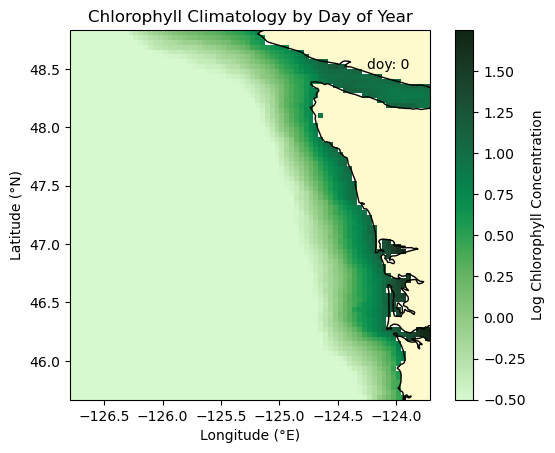

In [18]:
da = logchl_climate['CHL'] # Getting a data array instead of a dataset by selecting the 'CHL' variable

#PLOTTING
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree())) # Setting up plot with the PlateCarree projection
ax.coastlines(resolution = '10m') # Adding coastlines
ax.add_feature(cfeature.LAND, color = 'lemonchiffon') # Filling in landforms
# Plotting the first day of the year with pcolormesh
plot = ax.pcolormesh(da['longitude'], da['latitude'], da[0,:,:], transform = ccrs.PlateCarree(), cmap = 'cmo.algae', vmin = -0.5)
text = ax.annotate('doy:', xy = (-124.25, 48.5)) # Adding a day of the year label in the top right corner
fig.colorbar(plot, ax = ax, label = 'Log Chlorophyll Concentration') # Adding a colorbar

# Cartopy removes the tick marks, so I set them manually to every 0.5°
ax.set_xticks([-126.5, -126, -125.5, -125, -124.5, -124], crs=ccrs.PlateCarree())
ax.set_yticks([46, 46.5, 47, 47.5, 48, 48.5], crs=ccrs.PlateCarree())

# Labels
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
ax.set_title('Chlorophyll Climatology by Day of Year')

# Defining an update function to set the data that the pcolormesh plots to the next day
def update(frame):
    chla = da[frame,:,:] # sets the day to the frame that the animation is on
    plot.set_array(chla) # sets the array that pcolormesh plots
    text.set_text('doy: '+str(frame)) # sets the day of year marker to the correct day

ani = animation.FuncAnimation(fig = fig, func = update, frames = 366, interval = 60) # animates the plot using the update function and 366 frames (# of days in year)
ani.save('climatology_animation.gif') # saves the plot


**Fig. 1.** Animation of chlorophyll climatology. Each frame is one average day of logged chlorophyll concentrations. Chlorophyll is consistently highest near the coastline, and in the Strait of Juan de Fuca, with the greatest bloom extents around day 100 (mid-April) and day 275 (early October), corresponding to the spring and autumn blooms. The seasonality of chlorophyll can be visualized here, setting up further, more rigorous analyses.

## 2. KMeans Phenological Clustering  

<!-- In this cell, introduction the data set(s) you are working with, specify which aspect of your research question this section addresses, and describe the figure you will produce. -->

Now that I had the average time series for each grid cell, I wanted to see which areas were most similar to each other in their seasonality, to answer how it varies spatially. I did this using a type of machine learning model called k-means clustering, which is included in the package `tslearn`. I have two figures in this section: a map of the model's clusters, and the average time series corresponding to each.

In [ ]:
# the KMeans function needs a list or 2d array of time series, so I used the xarray stack function to flatten the data, then transposed it so that each time was a row
data_flat = logchl_climate['CHL'].stack(loc = ['latitude', 'longitude']).transpose()

# KMeans has an error if any time series are only nans, so I dropped any location where this was the case (land)
data_flat = data_flat.dropna('loc')

# To get accurate clustering based only on bloom timing, I standardized each time series. 
# Originally when I ran the model it only picked up on how far away from the coast the cell was because the mean concentration was dominating the phenology
data_flatz = stats.zscore(data_flat.data, axis = 1, nan_policy = 'omit')

### DO NOT RUN THIS NEXT CELL
It will take a very long time and crash the JupyterHub kernel immediately

In [ ]:
# !!!!! WARNING: Do not run this cell. It will take hours and if you run it on JupyterHub it will immediately crash the kernel.
# There are over 4000 time series in this. It took a really long time.

# Defining a model with 6 clusters, using the dynamic time warping distance metric. For more info on this model and dtw, see the tslearn documentation in the references
model = TimeSeriesKMeans(n_clusters = 6, metric = 'dtw', n_init = 3)

fit_z = model.fit_predict(data_flatz) # fitting the model with my data and then returning an array with the cluster of each grid cell

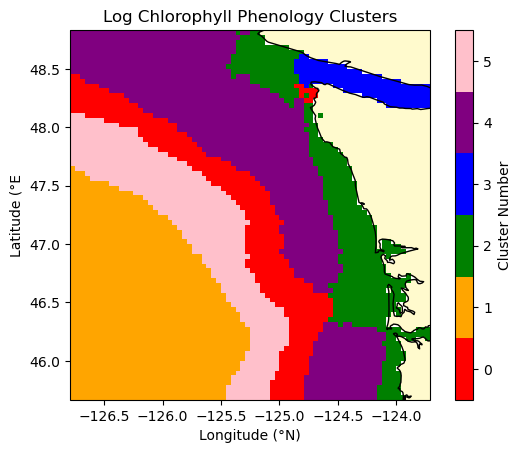

In [533]:
# Converting from a numpy array to xarray to make things easier.
clusters_z = xr.DataArray(fit_z, coords = {'loc':data_flat['loc']}).unstack('loc') # Unstacking the stacked index to get the lat and lon separately again

#PLOTTING
# Xarray has a built in plotting function that automatically selects pcolormesh!
p = clusters_z.plot(levels = [0, 1, 2, 3, 4, 5, 6], # setting discrete levels
                    colors = ['red', 'orange', 'green', 'blue', 'purple', 'pink'], # specifying the colors for the levels (none of the colormaps looked good here)
                    subplot_kws = dict(projection = ccrs.PlateCarree(),
                                       transform = ccrs.PlateCarree()), # setting Plate Carree projection
                   cbar_kwargs = dict(values = [0, 1, 2, 3, 4, 5], label = 'Cluster Number')) # Adding a colorbar with discrete values

# Map features
p.axes.coastlines() # adding coastlines
p.axes.add_feature(cfeature.LAND, color = 'lemonchiffon') # filling in landforms
# Cartopy removes the tick marks, so I set them manually to every 0.5°
plt.xticks([-126.5, -126, -125.5, -125, -124.5, -124])
plt.yticks([46, 46.5, 47, 47.5, 48, 48.5])

# Labels
plt.title('Log Chlorophyll Phenology Clusters')
plt.xlabel('Longitude (°N)')
plt.ylabel('Latitude (°E')

plt.savefig('clusterplot.png') # save figure


**Fig. 2.** Phenological clusters of logged chlorophyll time series from k-means clustering. Clusters seem mainly defined by their proximity to the coast, although there is a slight protrusion of cluster 2 (green) near the Columbia River outflow. There is also an area confined to the Strait of Juan de Fuca (cluster 3 - blue). These results suggest that phenology is largely defined by whether an area is on the continental shelf or in the upwelling region of the California Current.

In [659]:
# Creating a dataset from the standardized, flattened data, then unstacking the locations and assigning the data to the 'chla' variable
zscore = xr.DataArray(data_flatz, coords = [('loc', data_flat.get_index('loc')), ('time', np.arange(1, 367))]).unstack('loc').to_dataset(name = 'chla')
zscore = zscore.assign(cluster = clusters_z) # assigning a new variable: cluster, with the same dimensions as chla

# Defining a function to get the time series corresponding to each cluster
def get_cluster(array, num):
    # Gets chlorophyll time series from indices where cluster is equal to num
    mean_ts = array.where(array.cluster == num, drop = True)['chla'].stack(loc = ['latitude', 'longitude'])
    # returns the mean_ts array
    return mean_ts

# Getting the mean time series for each of the 6 clusters
zero_mean = get_cluster(zscore, 0).mean(axis = 1)
one_mean = get_cluster(zscore, 1).mean(axis = 1)
two_mean = get_cluster(zscore, 2).mean(axis = 1)
three_mean = get_cluster(zscore, 3).mean(axis = 1)
four_mean = get_cluster(zscore, 4).mean(axis = 1)
five_mean = get_cluster(zscore, 5).mean(axis = 1)

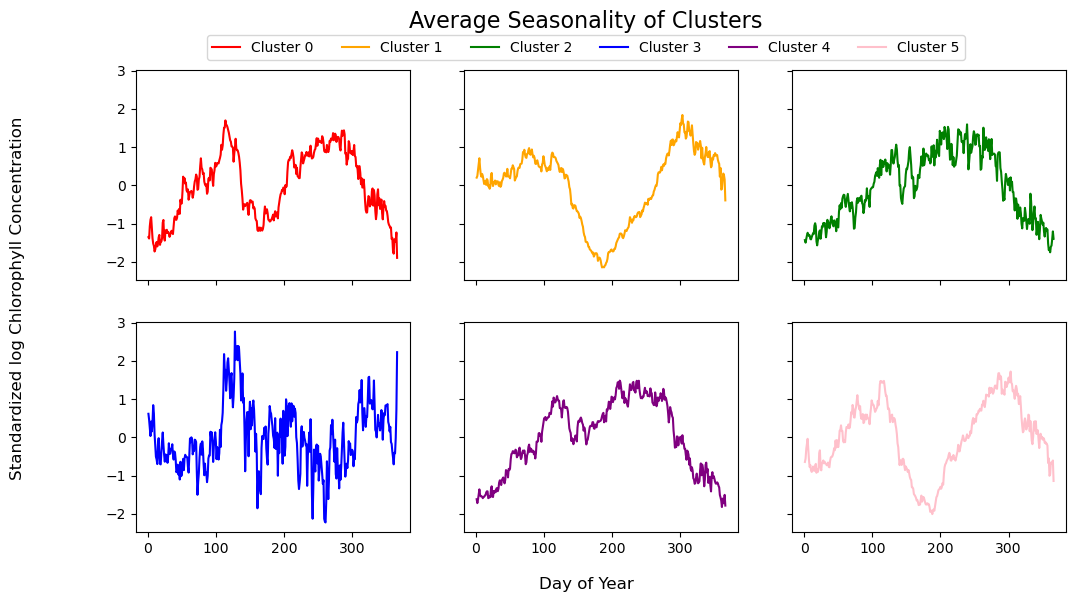

In [661]:
#Seasonality Plot
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6), sharex = True, sharey = True) # creating 2x3 plot with shared x and y axes

# Plotting each time series as a line plot with the same colors as the map
ax[0,0].plot(np.arange(1, 367), zero_mean, color = 'red', label = 'Cluster 0')        
ax[0,1].plot(np.arange(1, 367), one_mean, color = 'orange', label = 'Cluster 1')
ax[0,2].plot(np.arange(1, 367), two_mean, color = 'green', label = 'Cluster 2')
ax[1,0].plot(np.arange(1, 367), three_mean, color = 'blue', label = 'Cluster 3')
ax[1,1].plot(np.arange(1, 367), four_mean, color = 'purple', label = 'Cluster 4')
ax[1,2].plot(np.arange(1, 367), five_mean, color = 'pink', label = 'Cluster 5')

# Labels (sup means that the label is for the whole figure, not just one axes object
fig.suptitle('Average Seasonality of Clusters', fontsize = 16)
fig.supxlabel('Day of Year')
fig.supylabel('Standardized log Chlorophyll Concentration')
fig.legend(loc = 'upper center', bbox_to_anchor = (0.5, 0.95), ncol = 6) # Spreads out the legend with ncols = 6 and specifies the location with loc and bbox_to_anchor

# Save figure
fig.savefig('tsplot.png')

**Fig. 3.** Average standardized time series for each phenological cluster. Clusters 0, 1, and 5 (off-shelf) have the most defined spring and fall blooms, around days 100 and 300 respectively. Interestingly, both blooms seem to be approximately the same in magnitude for all clusters, contrary to the usual assumption that the spring bloom is more significant. Contrastingly, clusters 2 and 4 (on-shelf) have more of a sustained summer high, with peaks around day 250 for both, possibly because these areas are more dependent on upwelling in determining primary production than traditional critical depth theory expects. Cluster 3 (Juan de Fuca Strait) has a spring peak (~day 125) and is the most variable of the clusters. In general, clusters exhibit more variability as they approach the coast.

## 3. Bloom Timing Distribution Analysis  

<!-- In this cell, introduction the data set(s) you are working with, specify which aspect of your research question this section addresses, and describe the figure you will produce. -->

From the previous plot, you can see that there are clearly some differences in the timing of the blooms and how many there are. I wanted to look at this more closely by making a violin plot that shows the distributions of the peak timing for each cluster.

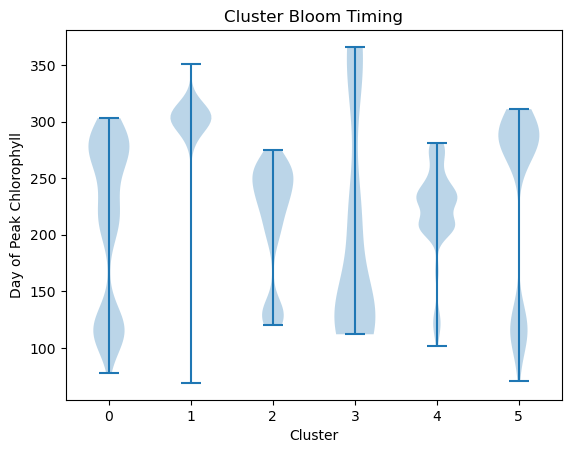

In [651]:
# Getting the peak for each time series grouped by cluster
peak = [] # initiating an empty list
# adding the peaks for each cluster to the list. Ends up with a list of six arrays
for x in range(6):
    orig = get_cluster(x) # getting the time series for the cluster
    ts_peak = orig.idxmax('time').data # finding the index (day of the year) of the peak chlorophyll concentration for each time series
    peak.append(ts_peak[~np.isnan(ts_peak)]) # adding the list of days to the peak list

#PLOTTING
fig, ax = plt.subplots() # initiating plot
ax.violinplot(peak) # Violin plot of the 'peak' array

# This is a fix so the x axis goes from 0 to 5 instead of 1 to 6
positions = [1, 2, 3, 4, 5, 6] # where each tick is located
labels = [0, 1, 2, 3, 4, 5] # the labels I want
ax.xaxis.set_major_locator(ticker.FixedLocator(positions)) # setting the tick locations
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels)) # setting the tick labels

#Labels
ax.set_xlabel('Cluster')
ax.set_ylabel('Day of Peak Chlorophyll')
ax.set_title('Cluster Bloom Timing')


# Save figure
fig.savefig('bloomtiming.png')

**Fig. 4.** Distribution of the day of peak chlorophyll for each phenological cluster. Spring peaks (days 100-150) are most common in cluster 3 (Juan de Fuca Strait), while all others have peaks more often in the late summer/fall (days 225-325). The summer peak described in the previous figure can be seen in clusters 2 and 4, while the spring/fall bloom distribution can be seen best in clusters 0 and 5. Cluster 3 has the most even spread in its peak timing due to the Juan de Fuca Strait's variability.

## Discussion
**Interpretation of Results:** 
<!-- Summarize what you learned from each data analysis section/figure. Discuss key insights and conclusions regarding your research question. Do your results support or contradict your hypothesis? -->
Through this analysis I sought to explore how phytoplankton phenology varies spatially in the Northern California Current. From the chlorophyll animation, we can see that there are two major bloom times in spring and autumn, although chlorophyll concentrations directly along the coast are consistently high, especially in the summer months. The clustering analysis revealed three major regions from six clusters: an off-shelf region with spring and fall blooms, an on-shelf, upwelling-driven region with one sustained summer peak, and a highly variable area in the Strait of Juan de Fuca. These results mostly supported my original hypotheses, although the effects of the Columbia River Plume and the Juan de Fuca Eddy were not as clear as I suspected.

**Limitations and Future Work:**  
<!-- Identify limitations in your analysis. Discuss any factors that may have impacted the validity or reliability of your results (e.g., data quality, sample size, assumptions). -->
<!-- What next steps could you or another researcher take to continue investigating this research question? Suggest ideas for further research, data collection, or alternative methodologies that could enhance understanding of the topic. -->
Although I have done my best to perform this analysis in a rigorous manner, caution should be used in extrapolating too much from these results. While Copernicus GlobColour is a widely used satellite chlorophyll data source, there are some concerns about its use in dynamic coastal environments like this study area, especially when a sizeable portion of yearly data is missing due to cloud cover (Pramlall et al. 2023). This might make the winter values I used inaccurate, as much of the data is missing during those months. The clustering model I used is also strictly analytical, and incorporates no prior knowledge of the system. In the future, I would like to try the clustering analysis with pre-defined centers (mean time series), to see if the results match other published analyses. I am also assuming that the phenology of this region is not dramatically changing with time. A future analysis could test this model on specific years to see if it holds up, or if there is substantial variation with time. Finally, I would like to apply other clustering methods, similarity metrics, and likelihood estimations (specifically Bayesian methods) to examine the data more thoroughly, and to see if k-means is truly the best method.

## References  

1. Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, L4 (monthly and interpolated) from Satellite Observations (1997-ongoing) *E.U. Copernicus Marine Service Information (CMEMS). Marine Data Store (MDS)*. DOI: 10.48670/moi-00281 (Accessed on 28 Oct 2024)  

2. Checkley, D. M., & Barth, J. A. (2009). Patterns and processes in the California Current System. *Progress in Oceanography, 83*(1–4), 49–64. https://doi.org/10.1016/j.pocean.2009.07.028

3. Hickey, B., & Banas, N. (2008). Why is the northern end of the California current system so productive? *Oceanography, 21*(4), 90–107. https://doi.org/10.5670/oceanog.2008.07

4. Pramlall, S., Jackson, J. M., Marchese, C., Suchy, K. D., Hunt, B. P. V., & Costa, M. (2024). Mapping phenoregions and phytoplankton seasonality in northeast Pacific Marine coastal ecosystems via a satellite-based approach. *Progress in Oceanography, 228*, 103336. https://doi.org/10.1016/j.pocean.2024.103336

5. *API reference*. API Reference - Matplotlib 3.9.3 documentation. (2024). https://matplotlib.org/stable/api/index.html#

6. *API reference*. xarray. (2024, December 5). https://docs.xarray.dev/en/latest/api.html

7. *API reference*. API Reference - tslearn 0.6.3 documentation. (2020). https://tslearn.readthedocs.io/en/stable/reference.html

8. *API reference*. API reference - cartopy 0.24.1 documentation. (2024, October 22). https://scitools.org.uk/cartopy/docs/latest/reference/index.html

9. *Statistical Functions (scipy.stats)*. Statistical functions (scipy.stats) - SciPy v1.14.1 Manual. (2024, August 20). https://docs.scipy.org/doc/scipy/reference/stats.html   